In [1]:
!kaggle --version

Kaggle API 1.5.12


In [2]:
# !kaggle competitions download -c m5-forecasting-accuracy

In [141]:
data_path = 'm5-forecasting-accuracy/'

# Libraries

In [142]:
import itertools
import pandas as pd
import numpy as np
from random import gauss, shuffle 

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox

from sklearn.metrics import mean_absolute_percentage_error as mape, mean_squared_error as mse
from scipy.stats import shapiro, probplot
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.cluster import KMeans

import os
import lightgbm as lgb

from  datetime import datetime, timedelta
import gc, copy

from gensim.models import Word2Vec 

import matplotlib.pyplot as plt
plt.style.use('seaborn') 

# Some general settings

In [143]:
# general settings
class CFG:
#     data_folder = 'm5-forecasting-accuracy/'
    img_dim1 = 20
    img_dim2 = 10
        
# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})   

In [144]:
# define the Root Mean Square Error, used in this competition for measuring accuracy
def my_rmse(x,y):
    return(np.round( np.sqrt(mse(x,y)) ,4))

# Format the data

In [145]:
xdat = pd.read_csv(data_path + 'sales_train_validation.csv')
xdat.shape

(30490, 1919)

Each row is an id, which is a combination of a specific item (sold at a specific department and of a specific category) and in a specific store. 

Each column (after the id's) is a day of sales, ranging from day 1 (d_1) until d_1913.

There is a total of 30490 id's, distributed over 3 states, 10 stores, 3 categories, 7 departments, 3049 products. 

Let's keep only the data for state CA:

In [146]:
xdat = xdat.loc[xdat.state_id == 'CA']

In [147]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


xdat = reduce_mem_usage(xdat)

Memory usage of dataframe is 178.65 MB
Memory usage after optimization is: 35.74 MB
Decreased by 80.0%


In [148]:
# convert from wide to long shape
xdat = pd.melt(xdat, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sales').dropna()

# get proper timestamps
xcal = pd.read_csv(data_path + 'calendar.csv')
xdat = pd.merge(xdat, xcal, on='d', how='left')
del xcal

In [149]:
xdat.drop(['d', 'wm_yr_wk', 'weekday', 'month', 'year',  'event_name_1', 'event_type_1', 
           'event_name_2', 'event_type_2', 'snap_TX', 'snap_WI', 'state_id'], 
                  axis = 1, inplace = True)
xdat.head(3)

,id,item_id,dept_id,cat_id,store_id,sales,date,wday,snap_CA
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0


# Traditional Smoothing Methods

In [150]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt

<AxesSubplot:xlabel='date'>

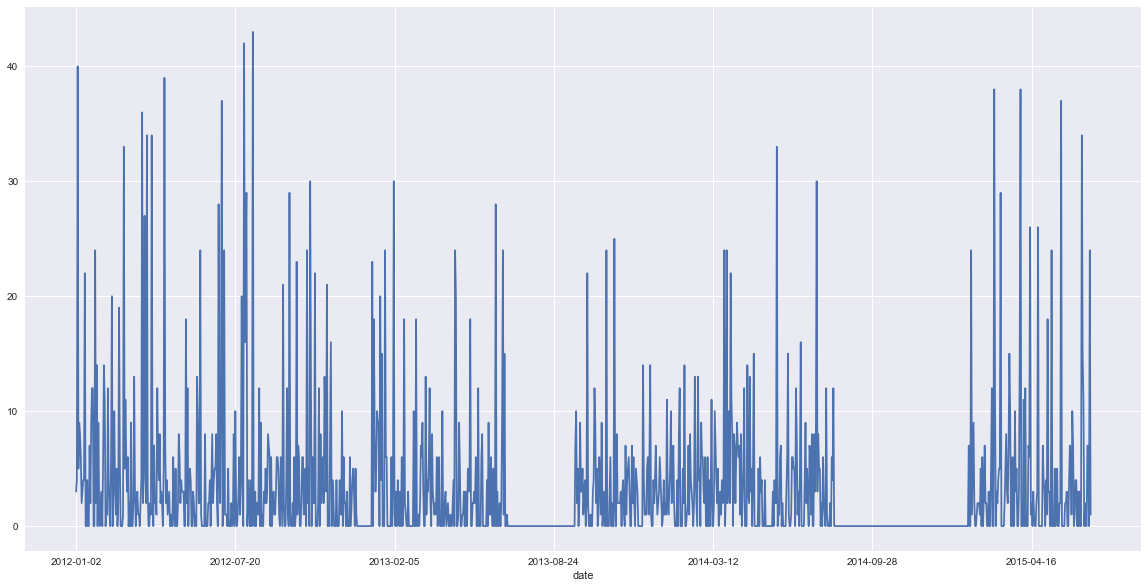

In [151]:
# select a random item in a random store to visualize and perform the smoothing methods on 
# (and only copy the date and sales to a new df) 

df = xdat.loc[(xdat.item_id == 'HOBBIES_1_288') & (xdat.store_id == 'CA_1')][['date', 'sales']].copy()
df = df.loc[(df.date > '2012-01-01') & (df.date < '2015-06-30')]
df.set_index('date').sales.plot()

In [152]:
df = df.set_index('date')
df.index = pd.to_datetime(df.index)

In [153]:
df.asfreq('D')

,sales
date,
2012-01-02,3
2012-01-03,4
2012-01-04,40
2012-01-05,5
2012-01-06,9
...,...
2015-06-25,7
2015-06-26,7
2015-06-27,0


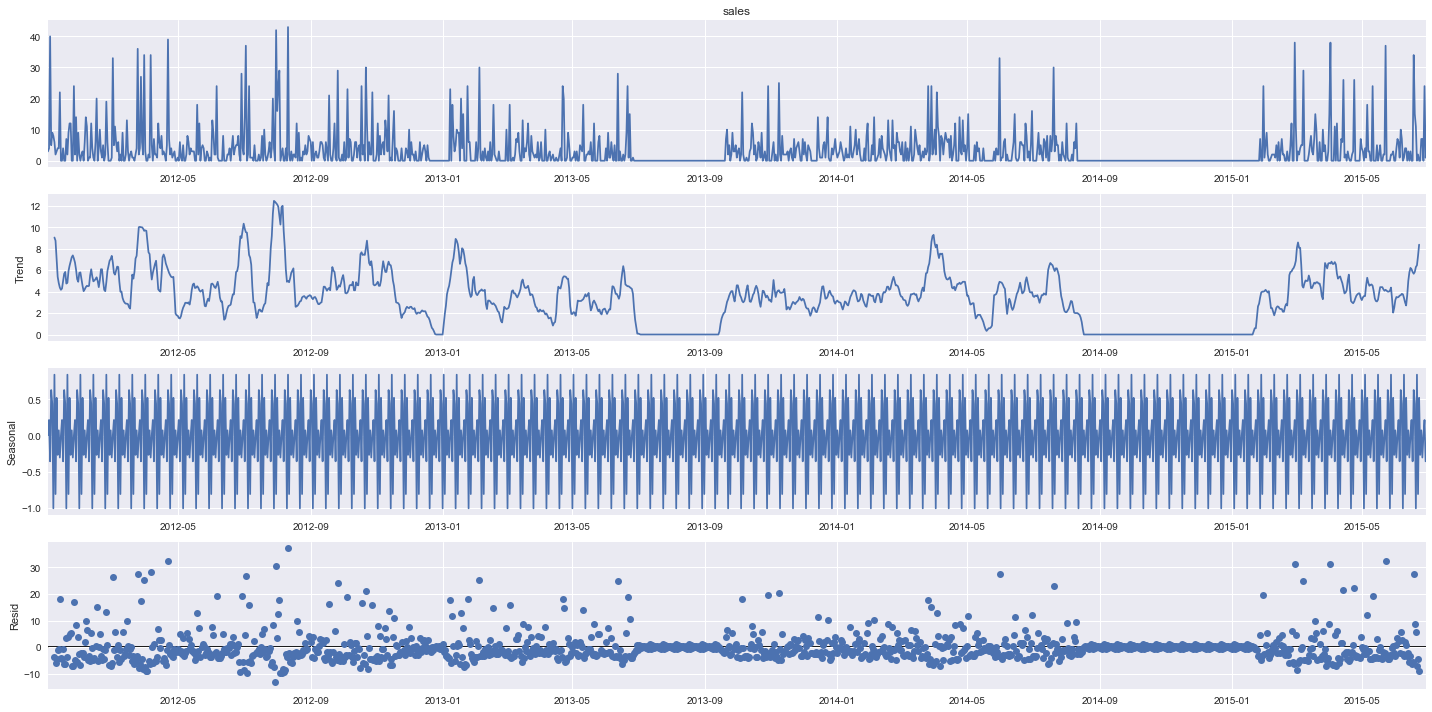

In [154]:
decomp = sm.tsa.seasonal_decompose(df['sales'], model='additive', filt=None, period=12, two_sided=True, extrapolate_trend=0)
figure = decomp.plot()
plt.show(figure)

/opt/homebrew/Caskroom/miniforge/base/envs/kaggle_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


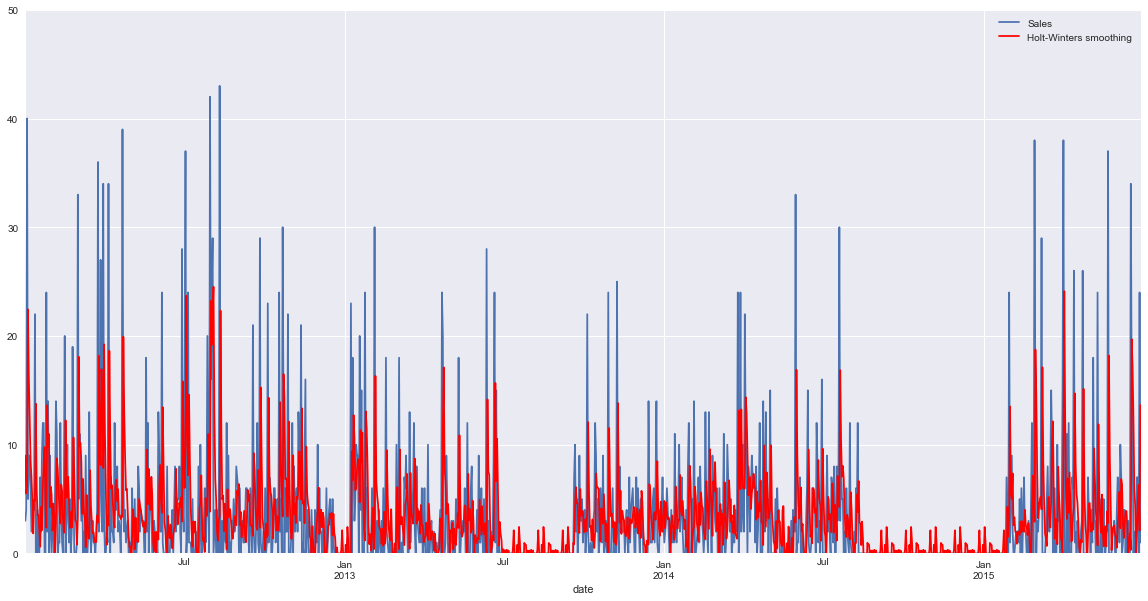

In [206]:
alpha = 0.5

df.sales.rename('Sales').plot.line(legend=True)


fit1 = ExponentialSmoothing(df, seasonal_periods=28, trend='add', seasonal='add')
fit1 = fit1.fit(smoothing_level=0.5)


fit1.fittedvalues.rename('Holt-Winters smoothing').plot(color='red', legend=True)
fit1.forecast().plot(color='red')

plt.ylim(0, 50)
# plt.xlim(['2012-01-01', '2015-07-30'])
plt.show()

In [210]:
results = pd.DataFrame(
    np.c_[df, fit1.level, fit1.trend, fit1.season, fit1.fittedvalues],
    columns=[r"$y_t$", r"$l_t$", r"$b_t$", r"$s_t$", "pred"],
    index=df.index,
)
results.append(fit1.forecast(8).rename(r"$\hat{y}_t$").to_frame(), sort=True)

results = results.loc[(results.index > '2012-01-01') & (results.index < '2015-06-30')]

/var/folders/_m/cq3r85ys541d12f3j4rnvfs80000gn/T/ipykernel_6011/3940906076.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results.append(fit1.forecast(8).rename(r"$\hat{y}_t$").to_frame(), sort=True)


In [211]:
results.head()

,$y_t$,$l_t$,$b_t$,$s_t$,pred
date,,,,,
2012-01-02,3.0,6.716236,-0.002598,-0.719108,8.995362
2012-01-03,4.0,5.956770,-0.002639,-1.200041,5.513737
2012-01-04,40.0,22.914377,-0.001732,0.128504,6.079508
2012-01-05,5.0,14.194075,-0.002198,-0.477112,22.437141
2012-01-06,9.0,10.564332,-0.002392,2.062544,16.255090


In [212]:
#calculate RMSE but only on the length of the df (so no foreacast)
print('RMSE:', my_rmse(df.sales,results.pred))

RMSE: 6.8829


## Optimize ExponentialSmoothing

In [216]:
def exp_smoothing_configs(seasonal=[None]):
    models = list()
    # define config lists
    t_params = ['add', 'mul', None]
    d_params = [True, False]
    s_params = ['add', 'mul', None]
    p_params = seasonal
    b_params = [True, False]
    r_params = [True, False]
    # create config instances
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            models.append(cfg)
    return models

cfg_list = exp_smoothing_configs(seasonal=[28]) #[0,6,12]

In [240]:
ts = df.copy()
ts.index = pd.DatetimeIndex(ts.index).to_period('D')

for j in range(len(cfg_list)):
#     print(j)
    try:
        cg = cfg_list[j]
        print(cg)
        t,d,s,p,b,r = cg

        # define model
        if (t == None):
            model = ExponentialSmoothing(ts, trend=t, seasonal=s, seasonal_periods=p)

        else:
            model = ExponentialSmoothing(ts, trend=t, damped_trend=d, seasonal=s, seasonal_periods=p)
        # fit model
        model_fit = model.fit(smoothing_level=0.5)#(optimized=True, use_boxcox=b, remove_bias=r)
        
        print('RMSE:', my_rmse(ts.sales,model_fit.fittedvalues))

    except:
       continue

['add', True, 'add', 28, True, True]
RMSE: 6.8924
['add', True, 'add', 28, True, False]
RMSE: 6.8924
['add', True, 'add', 28, False, True]
RMSE: 6.8924
['add', True, 'add', 28, False, False]
RMSE: 6.8924
['add', True, 'mul', 28, True, True]
['add', True, 'mul', 28, True, False]
['add', True, 'mul', 28, False, True]
['add', True, 'mul', 28, False, False]
['add', True, None, 28, True, True]
RMSE: 6.9516
['add', True, None, 28, True, False]
RMSE: 6.9516
['add', True, None, 28, False, True]
RMSE: 6.9516
['add', True, None, 28, False, False]
RMSE: 6.9516
['add', False, 'add', 28, True, True]
RMSE: 6.8829
['add', False, 'add', 28, True, False]
RMSE: 6.8829
['add', False, 'add', 28, False, True]
RMSE: 6.8829
['add', False, 'add', 28, False, False]
RMSE: 6.8829
['add', False, 'mul', 28, True, True]
['add', False, 'mul', 28, True, False]
['add', False, 'mul', 28, False, True]
['add', False, 'mul', 28, False, False]
['add', False, None, 28, True, True]
RMSE: 6.9517
['add', False, None, 28, True,

# Croston model
The Croston model is used to forecast time series with occurences of zeros, ie. days with zero sales. The model does the same:
1. it measures the average (of sales) for days with sales higher than 0 <br>
2. it estimates the number of days between two days with zero sales
3. calculates the sales as a function of the probability of having sales > 0 times the average level<br>


In summary: 
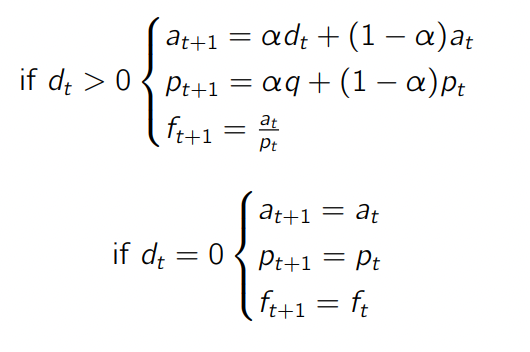

In [156]:
def Croston(ts,extra_periods=1,alpha=0.4):
    
    d = np.array(ts) # Transform the input into a numpy array
    cols = len(d) # Historical period length
    d = np.append(d,[np.nan]*extra_periods) # Append np.nan into the demand array to cover future periods
    
    #level (a), periodicity(p) and forecast (f)
    a,p,f = np.full((3,cols+extra_periods),np.nan)
    q = 1 #periods since last demand observation
    
    # Initialization
    first_occurence = np.argmax(d[:cols]>0)
    a[0] = d[first_occurence]
    p[0] = 1 + first_occurence
    f[0] = a[0]/p[0]
    # Create all the t+1 forecasts
    for t in range(0,cols):        
        if d[t] > 0:
            a[t+1] = alpha*d[t] + (1-alpha)*a[t] 
            p[t+1] = alpha*q + (1-alpha)*p[t]
            f[t+1] = a[t+1]/p[t+1]
            q = 1           
        else:
            a[t+1] = a[t]
            p[t+1] = p[t]
            f[t+1] = f[t]
            q += 1
       
    # Future Forecast 
    a[cols+1:cols+extra_periods] = a[cols]
    p[cols+1:cols+extra_periods] = p[cols]
    f[cols+1:cols+extra_periods] = f[cols]
                      
    df = pd.DataFrame.from_dict({"Demand":d,"Forecast":f,"Period":p,"Level":a,"Error":d-f})
    return df

In [160]:
print(len(df))
print(len(pred_croston))

1275
1303


In [168]:
pred_croston = Croston(df.sales, extra_periods=28, alpha=0.4)
pred_croston


,Demand,Forecast,Period,Level,Error
0,3.0,3.00000,1.000000,3.000000,0.000
1,4.0,3.00000,1.000000,3.000000,1.000
2,40.0,3.40000,1.000000,3.400000,36.600
3,5.0,18.04000,1.000000,18.040000,-13.040
4,9.0,12.82400,1.000000,12.824000,-3.824
...,...,...,...,...,...
1298,NaN,5.96253,1.498778,8.936507,NaN
1299,NaN,5.96253,1.498778,8.936507,NaN
1300,NaN,5.96253,1.498778,8.936507,NaN
1301,NaN,5.96253,1.498778,8.936507,NaN


In [178]:
# get proper timestamps
xcal = pd.read_csv(data_path + 'calendar.csv')
xcal = xcal.loc[(xcal.date >= '2012-01-01') & (xcal.date < '2015-08-28')]

xcal = xcal.reset_index(drop=True)
xcal

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2012-01-01,11149,Sunday,2,1,2012,d_338,NewYear,National,NaN,NaN,1,1,0
1,2012-01-02,11149,Monday,3,1,2012,d_339,NaN,NaN,NaN,NaN,1,0,1
2,2012-01-03,11149,Tuesday,4,1,2012,d_340,NaN,NaN,NaN,NaN,1,1,1
3,2012-01-04,11149,Wednesday,5,1,2012,d_341,NaN,NaN,NaN,NaN,1,0,0
4,2012-01-05,11149,Thursday,6,1,2012,d_342,NaN,NaN,NaN,NaN,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1330,2015-08-23,11530,Sunday,2,8,2015,d_1668,NaN,NaN,NaN,NaN,0,0,0
1331,2015-08-24,11530,Monday,3,8,2015,d_1669,NaN,NaN,NaN,NaN,0,0,0
1332,2015-08-25,11530,Tuesday,4,8,2015,d_1670,NaN,NaN,NaN,NaN,0,0,0
1333,2015-08-26,11530,Wednesday,5,8,2015,d_1671,NaN,NaN,NaN,NaN,0,0,0


In [171]:
pred_croston = pd.merge(pred_croston, xcal.date, left_index=True, right_index=True, how='left')
# del xcal

In [172]:
pred_croston.date = pd.to_datetime(pred_croston.date)
pred_croston = pred_croston.set_index(pred_croston.date)

pred_croston.head()

,Demand,Forecast,Period,Level,Error,date
date,,,,,,
2012-01-01,3.0,3.000,1.0,3.000,0.000,2012-01-01
2012-01-02,4.0,3.000,1.0,3.000,1.000,2012-01-02
2012-01-03,40.0,3.400,1.0,3.400,36.600,2012-01-03
2012-01-04,5.0,18.040,1.0,18.040,-13.040,2012-01-04
2012-01-05,9.0,12.824,1.0,12.824,-3.824,2012-01-05


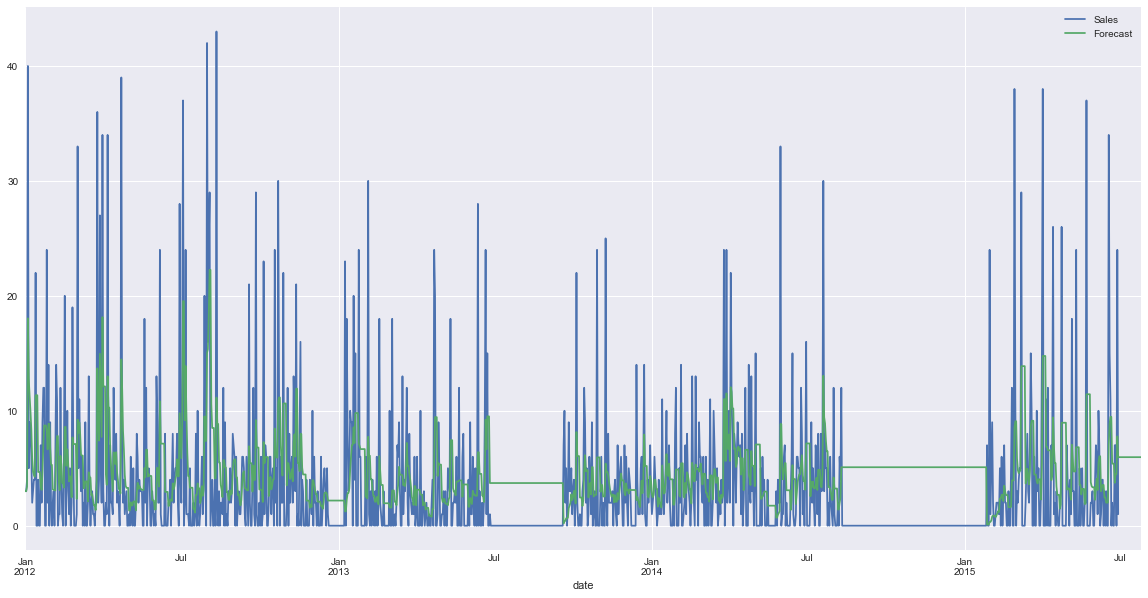

In [173]:
df.sales.rename('Sales').plot.line(legend=True)
pred_croston.Forecast.rename('Forecast').plot.line(legend=True)
plt.show()

Of course, the days without demand are a function of the days before ($a_{t+1} = a_t), so it will not get to 0 completely, as shown by the green line. Besides, the forecast is just a straight line as a function of the last observation.

In [174]:
#calculate RMSE but only on the length of the df (so no foreacast)
pred_croston = pred_croston.Forecast.head(len(df))
print('RMSE:', my_rmse(df.sales,pred_croston))

RMSE: 6.9649


# Extended Croston model
Now, let's look at an extended version of the Croston model, the Croston TBS

In [195]:
def Croston_TSB(ts,extra_periods=1,alpha=0.4,beta=0.1):
    d = np.array(ts) # Transform the input into a numpy array
    cols = len(d) # Historical period length
    d = np.append(d,[np.nan]*extra_periods) # Append np.nan into the demand array to cover future periods
    
    #level (a), probability(p) and forecast (f)
    a,p,f = np.full((3,cols+extra_periods),np.nan)
    # Initialization
    first_occurence = np.argmax(d[:cols]>0)
    a[0] = d[first_occurence]
    p[0] = 1/(1 + first_occurence)
    f[0] = p[0]*a[0]
                 
    # Create all the t+1 forecasts
    for t in range(0,cols): 
        if d[t] > 0:
            a[t+1] = alpha*d[t] + (1-alpha)*a[t] 
            p[t+1] = beta*(1) + (1-beta)*p[t]  
        else:
            a[t+1] = a[t]
            p[t+1] = (1-beta)*p[t]       
        f[t+1] = p[t+1]*a[t+1]
        
    # Future Forecast
    a[cols+1:cols+extra_periods] = a[cols]
    p[cols+1:cols+extra_periods] = p[cols]
    f[cols+1:cols+extra_periods] = f[cols]
                      
    df = pd.DataFrame.from_dict({"Demand":d,"Forecast":f,"Period":p,"Level":a,"Error":d-f})
    return df

In [196]:
pred_croston_tsb = Croston_TSB(df.sales, extra_periods=28, alpha=0.1, beta=0.1)
pred_croston_tsb

,Demand,Forecast,Period,Level,Error
0,3.0,3.000000,1.000000,3.000000,0.000
1,4.0,3.000000,1.000000,3.000000,1.000
2,40.0,3.100000,1.000000,3.100000,36.900
3,5.0,6.790000,1.000000,6.790000,-1.790
4,9.0,6.611000,1.000000,6.611000,2.389
...,...,...,...,...,...
1298,NaN,5.579656,0.633198,8.811865,NaN
1299,NaN,5.579656,0.633198,8.811865,NaN
1300,NaN,5.579656,0.633198,8.811865,NaN
1301,NaN,5.579656,0.633198,8.811865,NaN


In [197]:
pred_croston_tsb = pd.merge(pred_croston_tsb, xcal.date, left_index=True, right_index=True, how='left')
pred_croston_tsb


,Demand,Forecast,Period,Level,Error,date
0,3.0,3.000000,1.000000,3.000000,0.000,2012-01-01
1,4.0,3.000000,1.000000,3.000000,1.000,2012-01-02
2,40.0,3.100000,1.000000,3.100000,36.900,2012-01-03
3,5.0,6.790000,1.000000,6.790000,-1.790,2012-01-04
4,9.0,6.611000,1.000000,6.611000,2.389,2012-01-05
...,...,...,...,...,...,...
1298,NaN,5.579656,0.633198,8.811865,NaN,2015-07-22
1299,NaN,5.579656,0.633198,8.811865,NaN,2015-07-23
1300,NaN,5.579656,0.633198,8.811865,NaN,2015-07-24
1301,NaN,5.579656,0.633198,8.811865,NaN,2015-07-25


In [198]:
pred_croston_tsb.date = pd.to_datetime(pred_croston_tsb.date)
pred_croston_tsb


,Demand,Forecast,Period,Level,Error,date
0,3.0,3.000000,1.000000,3.000000,0.000,2012-01-01
1,4.0,3.000000,1.000000,3.000000,1.000,2012-01-02
2,40.0,3.100000,1.000000,3.100000,36.900,2012-01-03
3,5.0,6.790000,1.000000,6.790000,-1.790,2012-01-04
4,9.0,6.611000,1.000000,6.611000,2.389,2012-01-05
...,...,...,...,...,...,...
1298,NaN,5.579656,0.633198,8.811865,NaN,2015-07-22
1299,NaN,5.579656,0.633198,8.811865,NaN,2015-07-23
1300,NaN,5.579656,0.633198,8.811865,NaN,2015-07-24
1301,NaN,5.579656,0.633198,8.811865,NaN,2015-07-25


In [200]:
pred_croston_tsb = pred_croston_tsb.set_index(pred_croston_tsb.date)
pred_croston_tsb

,Demand,Forecast,Period,Level,Error,date
date,,,,,,
2012-01-01,3.0,3.000000,1.000000,3.000000,0.000,2012-01-01
2012-01-02,4.0,3.000000,1.000000,3.000000,1.000,2012-01-02
2012-01-03,40.0,3.100000,1.000000,3.100000,36.900,2012-01-03
2012-01-04,5.0,6.790000,1.000000,6.790000,-1.790,2012-01-04
2012-01-05,9.0,6.611000,1.000000,6.611000,2.389,2012-01-05
...,...,...,...,...,...,...
2015-07-22,NaN,5.579656,0.633198,8.811865,NaN,2015-07-22
2015-07-23,NaN,5.579656,0.633198,8.811865,NaN,2015-07-23
2015-07-24,NaN,5.579656,0.633198,8.811865,NaN,2015-07-24


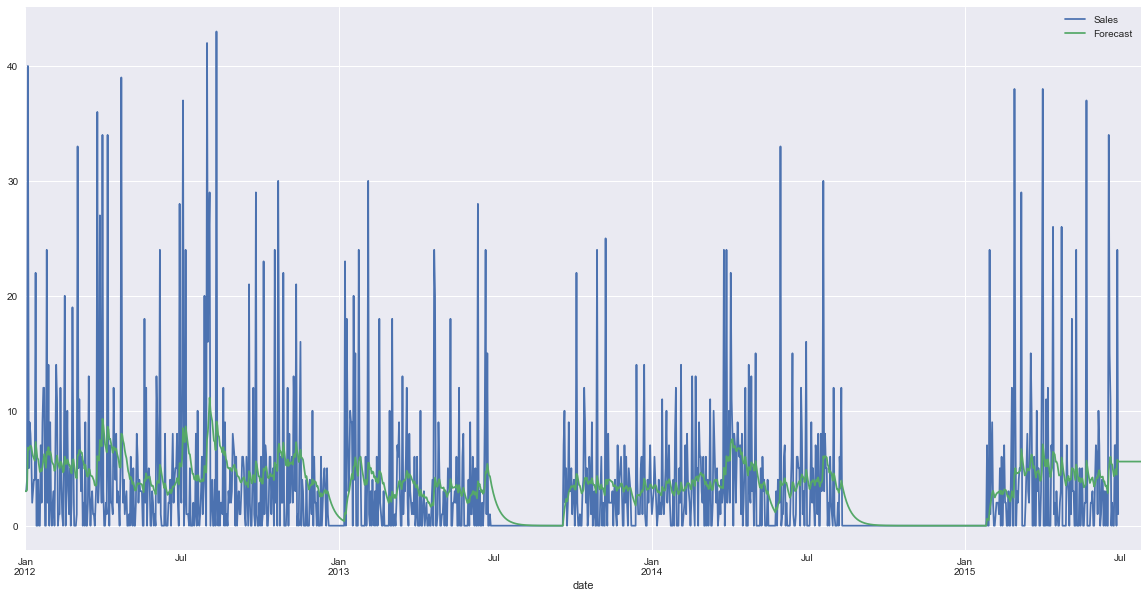

In [201]:
df.sales.rename('Sales').plot.line(legend=True)
pred_croston_tsb.Forecast.rename('Forecast').plot.line(legend=True)
plt.show()

In [202]:
#calculate RMSE but only on the length of the df (so no foreacast)
pred_croston_tsb = pred_croston_tsb.Forecast.head(len(df))
print('RMSE:', my_rmse(df.sales,pred_croston_tsb))

RMSE: 6.1353


This RMSE is (finally) a bit better than the Holt-Winters and normal Croston model. 